# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# !pip install --upgrade transformers wordcloud Pillow -q

# install CUDA from official NVidia website
# check the command on the official PyTorch website:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# !pip install -U pip setuptools wheel
# !pip install -U spacy

In [2]:
# помним про PEP-8
# импорты из стандартной библиотеки
import warnings
import string

# импорты сторонних библиотек
import nltk
import numpy as np
import pandas as pd
import spacy
import torch
import transformers
from wordcloud import WordCloud

# импорты модулей текущего проекта
# длина строки до 78 символов
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertModel, BertTokenizer, pipeline
from tqdm.notebook import tqdm
from scipy import sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# настройки
warnings.filterwarnings("ignore")
%matplotlib inline
tqdm.pandas()

# константы заглавными буквами
RANDOM_STATE = 42

In [3]:
transformers.__version__

'4.39.3'

In [4]:
torch.cuda.is_available()

True

In [5]:
base = 'C:/Users/anton/OneDrive/data_science/yandex_practicum/datasets/'
data = pd.read_csv(base + 'toxic_comments.csv', index_col='Unnamed: 0', keep_default_na=False)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [7]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Доля токсичных комментариев: 0.10161213369158527


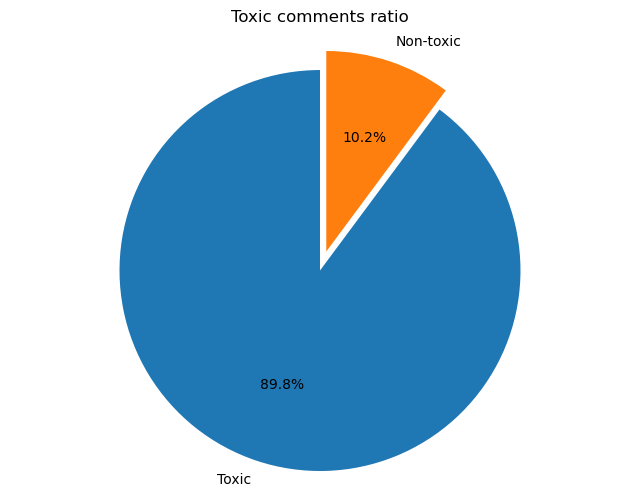

In [8]:
print('Доля токсичных комментариев:', data['toxic'].mean())

non_toxic_count = len(data[data['toxic'] == 0])
toxic_count = len(data[data['toxic'] == 1])
size = [non_toxic_count, toxic_count]

plt.figure(figsize=(8, 6))
plt.pie(size, explode=(0.1, 0), labels=['Toxic', 'Non-toxic'],\
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')

plt.title('Toxic comments ratio')
plt.show()

Датасет имеет 159292 сэмплов комментариев, около 10% которых - токсичные.

## Обучение TF-IDF

### Preprocessing

#### WordNetLemmatizer

In [9]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('tagsets')

In [10]:
punct_to_drop = list(string.punctuation) + list(['`', '·', '``'])
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def preprocess_text_no_punct(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if (token not in punct_to_drop
                                            and token not in stop_words
                                            and not token.isdigit()
                                           and token.isalnum())]
    lemmas = [lemmatizer.lemmatize(token, pos='n') for token in tokens]
    return ' '.join(lemmas)

try:
    data['nltk_no_punct'] = pd.read_csv(base + 'nltk_no_punct.csv', index_col='Unnamed: 0', keep_default_na=False)
    print('Data nltk_no_punkt were loaded from local directory')
except:
    data['nltk_no_punct'] = data['text'].progress_apply(preprocess_text_no_punct)
    data['nltk_no_punct'].to_csv(base + 'nltk_no_punct.csv')


def preprocess_text_w_punct(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if (token not in stop_words
                                            and not token.isdigit())]
    lemmas = [lemmatizer.lemmatize(token, pos='n') for token in tokens]
    return ' '.join(lemmas)

try:
    data['nltk_w_punct'] = pd.read_csv(base + 'nltk_w_punct.csv', index_col='Unnamed: 0', keep_default_na=False)
    print('Data nltk_w_punct were loaded from local directory')
except:
    data['nltk_w_punct'] = data['text'].progress_apply(preprocess_text_w_punct)
    data['nltk_w_punct'].to_csv(base + 'nltk_w_punct.csv')

Data nltk_no_punkt were loaded from local directory
Data nltk_w_punct were loaded from local directory


#### SpaCy

In [11]:
# efficiency
# !python -m spacy download en_core_web_sm -q

# accuracy
# !python -m spacy download en_core_web_trf

# russian
# !python -m spacy download ru_core_news_lg

In [12]:
spacy_pipeline = spacy.load('en_core_web_sm')

# Функция для предобработки через SpaCy
def preprocess_spacy(text):
    spacy_data = spacy_pipeline(text.lower())
    lemmas = [token.lemma_ for token in spacy_data if (not token.is_stop
                                                   and not token.is_punct
                                                   and not token.lemma_.isdigit()
                                                   and token.lemma_.isalnum() # for simplicity, space for improvement
                                                   and token.lemma_ != '\n')]
    return ' '.join(lemmas)

try:
    data['spacy_no_punct'] = pd.read_csv(base + 'spacy_no_punct.csv', index_col='Unnamed: 0', keep_default_na=False)
    print('Data spacy_no_punct were loaded from local directory')
except:
    data['spacy_no_punct'] = data['text'].progress_apply(preprocess_spacy)
    data['spacy_no_punct'].to_csv(base + 'spacy_no_punct.csv')

Data spacy_no_punct were loaded from local directory


### Word Cloud

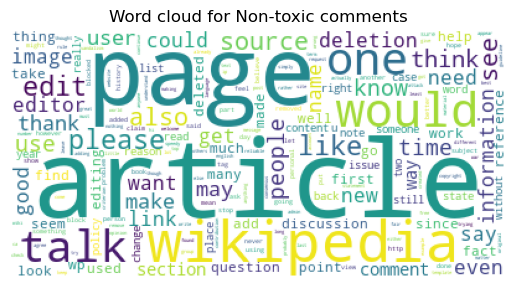

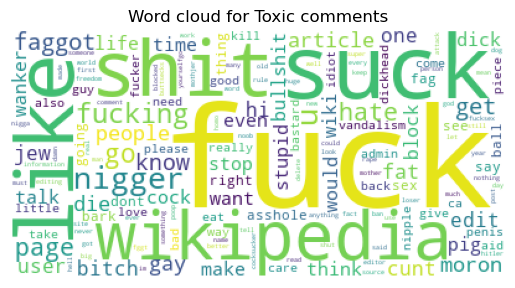

In [13]:
good_wordcloud = WordCloud(
    stopwords=stop_words,
    collocations=False,
    background_color='white'
).generate(''.join(data[data['toxic'] == 0]['nltk_no_punct']))

plt.imshow(good_wordcloud)
plt.title('Word cloud for Non-toxic comments')
plt.axis('off')
plt.show()

toxic_wordcloud = WordCloud(
    stopwords=stop_words,
    collocations=False,
    background_color='white'
).generate(''.join(data[data['toxic'] == 1]['nltk_no_punct']))
plt.imshow(toxic_wordcloud)
plt.title('Word cloud for Toxic comments')
plt.axis('off')
plt.show()

### Prediction

In [14]:
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    stratify=data['toxic'],
    random_state=RANDOM_STATE
)

data_train.shape, data_test.shape

# Функция для предсказаний и подбора порога
def tune_threshold(model, X, y, thresholds):
    best_score = 0
    best_threshold = 0
    y_pred_proba = model.predict_proba(X)

    for threshold in thresholds:
        y_pred = np.where(y_pred_proba[:, 1] >= threshold, 1, 0)
        score = f1_score(y, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_score, best_threshold

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model',LogisticRegression(random_state=RANDOM_STATE))
])

params={
    'model__C':[0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'model__penalty':[None, 'l1','l2'],
    'tfidf__ngram_range':[(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
}
params = {}

grid_search = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1')
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1, param_grid={}, scoring='f1')

In [15]:
%%time

# Обучаемся на данных NLTK без пунктуации
grid_search.fit(data_train['nltk_no_punct'], data_train['toxic'])
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

thresholds = np.arange(0.1, 0.9, 0.1)
score_word_level, threshold_word_level = tune_threshold(
    grid_search,
    data_train['nltk_no_punct'],
    data_train['toxic'],
    thresholds
)

print('Результат F1', score_word_level)
print('Порог', threshold_word_level)

{}
0.730662567255743
Результат F1 0.8329267391143639
Порог 0.2
CPU times: total: 17.7 s
Wall time: 17.6 s


0.730662567255743
Результат F1 0.8329267391143639
Порог 0.2

In [16]:
%%time

# Обучаемся на данных NLTK без пунктуации
grid_search.fit(data_train['nltk_w_punct'], data_train['toxic'])
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

thresholds = np.arange(0.1, 0.9, 0.1)
score_word_level, threshold_word_level = tune_threshold(
    grid_search,
    data_train['nltk_w_punct'],
    data_train['toxic'],
    thresholds
)

print('Результат F1', score_word_level)
print('Порог', threshold_word_level)

{}
0.7283600895368532
Результат F1 0.8367685557317207
Порог 0.2
CPU times: total: 19.7 s
Wall time: 19 s


0.7283600895368532
Результат F1 0.8367685557317207
Порог 0.2

In [17]:
%%time

# Обучаемся на данных после SpaCy лемматизации
grid_search.fit(data_train['spacy_no_punct'], data_train['toxic'])
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params)
print(best_score)

thresholds = np.arange(0.1, 0.9, 0.1)
score_word_level, threshold_word_level = tune_threshold(
    grid_search,
    data_train['spacy_no_punct'],
    data_train['toxic'],
    thresholds
)

print('Результат F1', score_word_level)
print('Порог', threshold_word_level)

{}
0.7317442099621887
Результат F1 0.8306737588652482
Порог 0.2
CPU times: total: 14.7 s
Wall time: 15.4 s


Результат F1 0.8306737588652482
Порог 0.2

## Обучение BERT

### Получение Эмбеддингов

In [18]:
# Функция для токенизации
def preprocess_text(texts):
    encoded = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    return encoded['input_ids'], encoded['attention_mask']

# Функция для получения эмбеддингов
def generate_embeddings(model, input_ids, input_mask, batch_size, device):
    embeddings = torch.LongTensor()
    for i in tqdm(range(input_ids.shape[0] // batch_size)):
        # Slice by batch size
        batch_ids = input_ids[batch_size*i:batch_size*(i+1)]
        batch_mask = input_mask[batch_size*i:batch_size*(i+1)]

        # Send batch to GPU if available
        if torch.cuda.is_available():
            batch_ids = batch_ids.to(device)
            batch_mask = batch_mask.to(device)
        
        # Generate embeddings
        with torch.no_grad():
            batch_outputs = model(batch_ids, attention_mask=batch_mask)
            # embeddings = outputs['pooler_output']
            batch_embeddings = batch_outputs['last_hidden_state'][:,0,:]

        # Send back to CPU if needed
        if torch.cuda.is_available():
            batch_embeddings = batch_embeddings.to('cpu')
        
        embeddings = torch.cat((embeddings, batch_embeddings))
    return embeddings

In [19]:
model_bert = transformers.AutoModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

# Передаем модель в доступный девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model_bert = model_bert.to(device)
print('Работаем на:', device)

try:
    data_bert = pd.read_csv(base + 'data_bert.csv', index_col='Unnamed: 0', keep_default_na=False)
    
    print('Features were loaded from local directory')
except:
    print('Failed to load data from local directory')

    data_bert, _ = train_test_split(
        data[['text', 'toxic']],
        train_size=30000,
        stratify=data['toxic'],
        random_state=RANDOM_STATE
    )
    data_bert.reset_index(drop=True, inplace=True)
    
    # Токенизация
    data_ids, data_mask = preprocess_text(data_bert['text'].tolist())

    # Получение Эмбеддигнов
    batch_size = 10
    embeddings = generate_embeddings(model_bert, data_ids, data_mask, batch_size, device)

    data_bert = data_bert[:embeddings.shape[0]]
    data_bert = pd.concat([data_bert, pd.DataFrame(embeddings)], axis=1)

    data_bert.to_csv(base + 'data_bert.csv')

data_bert.head()

Работаем на: cuda
Features were loaded from local directory


,text,toxic,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,Just another white supremacist dog. 'nuff said...,1,-0.304410,0.608470,0.126564,-0.276581,-0.175715,0.819380,0.823409,0.780872,...,-0.930473,0.861368,-0.494970,-0.514111,-0.463953,-0.858322,0.366550,-0.532473,-0.088587,0.015288
1,youtube link? the peaches video parody has a y...,0,-0.507304,-0.953592,1.053713,-0.213297,0.828757,0.831682,0.373391,0.419427,...,-0.737584,-0.756316,0.237383,-0.425055,-0.295833,0.330939,-0.243216,-0.358237,0.971341,0.274354
2,Resolved. See Talk:Peachey Carnehan. tc 2007 ...,0,-0.568855,-0.935522,0.447104,-0.427495,0.859172,0.239811,-0.106442,0.130574,...,-0.648330,-1.167350,0.202807,-0.712166,0.166058,0.995385,-0.492111,-0.772893,0.496585,0.107918
3,"Welcome!\n\nHello, Klhrdy, and welcome to Wiki...",0,-0.706652,-0.691415,0.737169,-0.466923,1.028671,0.214050,-0.068515,0.102484,...,-0.370423,-1.151746,0.476212,-0.686037,0.065828,0.753317,-0.536061,-0.645964,0.475216,0.107548
4,Tony Award Discussion \n\nHello - there is a ...,0,-0.746066,-0.936316,0.693636,-0.243457,0.959380,0.192346,-0.300145,0.134590,...,-0.543062,-1.217241,0.330498,-0.672251,0.043531,0.899550,-0.593268,-0.637088,0.452506,0.163728


### Prediction

In [20]:
# Разбиваем обработанные данные на 3 части
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    data_bert.drop(['toxic', 'text'], axis=1), data_bert['toxic'],
    test_size=0.5,
    stratify=data_bert['toxic'],
    random_state=RANDOM_STATE
)

print(
    X_train_bert.shape, y_train_bert.shape,
    X_test_bert.shape, y_test_bert.shape
)

(1500, 768) (1500,) (1500, 768) (1500,)


In [21]:
params={
    'C':[0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'penalty':[None, 'l1','l2']
}

grid_search = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE), cv=5, n_jobs=-1, param_grid=params, scoring='f1')

grid_search.fit(X_train_bert, y_train_bert)

thresholds_range = np.arange(0.1, 0.9, 0.1)
score_bert, threshold_bert = tune_threshold(
    grid_search,
    X_train_bert,
    y_train_bert,
    thresholds_range
)

print('Результат для bert', score_bert)
print('Порог', threshold_bert)

Результат для bert 0.9514563106796117
Порог 0.4


## Test Bert

In [22]:
threshold_final = threshold_bert
y_pred_proba = grid_search.predict_proba(X_test_bert)
y_pred = np.where(y_pred_proba[:, 1] >= threshold_final, 1, 0)
score_test = f1_score(y_test_bert, y_pred)

print('Результат на тесте', score_test)

Результат на тесте 0.9483870967741936


## Выводы

**TF-IDF пайплайн:**
1. Токенизация: WordNetLemmatizer и SpaCy.
2. TF-IDF векторизация
3. Обучение модели - Линейная регрессия
4. Подбор порога

Результат: F1 = 0.84

**Bert model пайплайн**
1. Токенизация: `transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')`
2. Получение эмбеддингов: `transformers.AutoModel.from_pretrained('unitary/toxic-bert')`
3. Обучение модели - Линейная регрессия
4. Подбор порога

Обучение проводилось на локальном GPU NVidia RTX3060 на неполных данных: 30000 комментариев.

Результат: F1 = 0.95

Результат с Bert на тесте: F1 = 0.95